In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from trajectories import TrajectoriesDataset, StateFullTrajectoriesDataset, preprocess_dataset, find_activations
from torch.utils.data import DataLoader
from reward_shaping import SECRETRewardShaper
import os

%load_ext autoreload
%autoreload 2


In [3]:
shaper = SECRETRewardShaper(model_path='agents/MiniGrid-Triggers-3x3-T1P1-v0/best_model.pt',
                            shaping_path='agents/MiniGrid-Triggers-3x3-T1P1-v0/reward_shaping.pt',
                            dataset_path='agents/MiniGrid-Triggers-3x3-T1P1-v0/random/trajectories/train_5000_both.pt',
                            use_full_obs=True)

100%|██████████| 5000/5000 [09:02<00:00,  9.22it/s, Uniques states: 63907]


In [4]:
len(list(shaper.potential.keys()))

245000

In [2]:
torch.set_printoptions(threshold=10000)

shaper = SECRETRewardShaper(model_path='agents/MiniGrid-Triggers-3x3-T1P1-v0/best_model.pt',
                            shaping_path='agents/MiniGrid-Triggers-3x3-T1P1-v0/reward_shaping.pt',
                            dataset_path='agents/MiniGrid-Triggers-3x3-T1P1-v0/random/trajectories/train_5000_both.pt',
                            use_full_obs=True)


  0%|          | 0/65641 [00:00<?, ?it/s]States shape before: torch.Size([5000, 50, 24, 24, 3])
Unique states shape: torch.Size([65641, 64, 64, 3])
/home/mbaliesnyi/anaconda3/envs/rl/lib/python3.8/site-packages/torch/tensor.py:758: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:930.)
  return super(Tensor, self).refine_names(names)
  1%|          | 329/65641 [27:05<89:37:05,  4.94s/it]


KeyboardInterrupt: 

In [2]:
potential_vals = torch.tensor(list(shaper.potential.values()))

torch.where(torch.abs(potential_vals) > 0)

potential_vals

tensor(-0.0018, device='cuda:0')


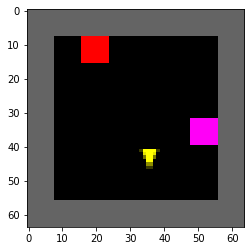

In [75]:
obs = list(shaper.potential.keys())[1029]

print(shaper.potential[obs])

plt.imshow(obs.type(torch.int32))

In [8]:
# data_path = 'agents/MiniGrid-Triggers-7x7-T1P1-v0/random/trajectories/test_5000.pt'

# dataset = torch.load(data_path)
# print('before',dataset.rewards.dtype)

# dataset.rewards = dataset.rewards.long()

# print('after',dataset.rewards.dtype)

# torch.save(dataset, data_path)
# print('done!')

before torch.float32
after torch.int64


In [11]:
from config import PAD_VAL
from trajectories import TrajectoriesDataset
import os
import gc

device = torch.device('cpu')
seed = 128

# REMEMBER to mix the TEST set, too
def create_mixed_dataset(data_path_1, data_path_2, output_path, output_size, convert_rewards=[], pad_rewards=True):
    print('func called!')

    # load dataset 1, get a subset of it and cleanup
    dataset_1 = torch.load(data_path_1)
    perm = torch.randperm(dataset_1.actions.shape[0])
    indices = perm[:output_size//2]

    dataset_1_obs = dataset_1.observations[indices].detach().clone()
    dataset_1_act = dataset_1.actions[indices].detach().clone()
    dataset_1_rew = dataset_1.rewards[indices].detach().clone()

    # convert rewards to classes
    if data_path_1 in convert_rewards:
        dataset_1_rew += 1

    del perm
    del indices
    del dataset_1
    gc.collect()

    # load dataset 2, get a subset of it and cleanup
    dataset_2 = torch.load(data_path_2)
    perm = torch.randperm(dataset_2.actions.shape[0])
    indices = perm[:output_size//2]

    dataset_2_obs = dataset_2.observations[indices].detach().clone()
    dataset_2_act = dataset_2.actions[indices].detach().clone()
    dataset_2_rew = dataset_2.rewards[indices].detach().clone()

    # convert rewards to classes
    if data_path_2 in convert_rewards:
        dataset_2_rew += 1
    
    del perm
    del indices
    del dataset_2
    gc.collect()
    print('loaded datasets!')

    combined_obs = torch.vstack((dataset_1_obs, dataset_2_obs))
    combined_act = torch.vstack((dataset_1_act, dataset_2_act))
    combined_rew = torch.vstack((dataset_1_rew, dataset_2_rew))
    del dataset_1_obs
    del dataset_1_act
    del dataset_1_rew
    del dataset_2_obs
    del dataset_2_act
    del dataset_2_rew
    gc.collect()
    print('combined data!')

    print('shuffle dataset')
    perm = torch.randperm(combined_rew.shape[0])
    shuffled_obs = combined_obs[perm]
    shuffled_act = combined_act[perm]
    shuffled_rew = combined_rew[perm]
    print('shuffled dataset!')

    print('about to create dataset obj')
    mixed_dataset = TrajectoriesDataset(shuffled_obs, shuffled_act, shuffled_rew)
    print('done with dataset obj')

    print('about to start loop')
    ep = 0
    while 10 not in mixed_dataset.actions[ep]:
        ep += 1

    print('actions:', mixed_dataset.actions[ep])
    print('-- BEFORE --')
    print('rewards:', mixed_dataset.rewards[ep])

    # pad rewards
    padding_mask = (mixed_dataset.actions[:, :, 0] == PAD_VAL)
    mixed_dataset.rewards[padding_mask] = PAD_VAL 
    mixed_dataset.rewards = mixed_dataset.rewards.long()

    print('-- AFTER --')
    print('rewards:', mixed_dataset.rewards[ep])

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    torch.save(mixed_dataset, output_path)

    rewards = mixed_dataset.rewards.detach().clone()
    del shuffled_obs
    del shuffled_act
    del shuffled_rew
    del padding_mask
    del mixed_dataset
    gc.collect()

    # plot reward distribution
    print('Getting uniques..')
    unique_rewards_per_episode = [torch.unique(rewards[episode]).tolist() for episode in range(rewards.shape[0])]
    print('Got uniques. Plotting...')

    n_episodes_positive_reward = 0
    n_episodes_negative_reward = 0
    for episode_reward_vals in unique_rewards_per_episode:
        if 2 in episode_reward_vals:
            n_episodes_positive_reward += 1
        if 0 in episode_reward_vals:
            n_episodes_negative_reward += 1

    n_episodes_no_reward = rewards.shape[0] - n_episodes_positive_reward - n_episodes_negative_reward
    reward_vals = torch.tensor([n_episodes_negative_reward, n_episodes_no_reward, n_episodes_positive_reward])

    print(f'Positive: {n_episodes_positive_reward} | Negative: {n_episodes_negative_reward}')


    plt.figure(figsize=(6,5))
    plt.title('Mixed dataset: reward distribution')
    plt.xlabel('Reward sign faced within an episode')
    plt.ylabel('%\ of episodes')
    plt.bar(torch.arange(0, 3)-1, reward_vals/torch.sum(reward_vals), tick_label=['Negative', 'Zero', 'Positive'])
    plt.show()


func called!
loaded datasets!
combined data!
shuffle dataset
shuffled dataset!
about to create dataset obj
done with dataset obj
about to start loop
actions: tensor([[ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10.

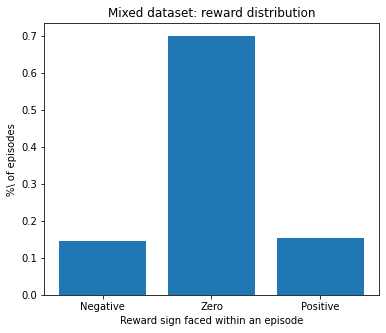

In [14]:
# data_neg_path = 'agents/MiniGrid-Triggers-5x5-T1P1-v0/random/trajectories/train_10000.pt'
# data_pos_path = 'agents/MiniGrid-Triggers-5x5-T1P1-v0/ep15000/trajectories/train.pt'
# output_path = 'agents/MiniGrid-Triggers-5x5-T1P1-v0/mixed/trajectories/train_10000.pt'

data_neg_path = 'agents/MiniGrid-Triggers-5x5-T1P1-v0/random/trajectories/test_5000.pt'
data_pos_path = 'agents/MiniGrid-Triggers-5x5-T1P1-v0/ep15000/trajectories/test.pt'
output_path = 'agents/MiniGrid-Triggers-5x5-T1P1-v0/mixed/trajectories/test_5000.pt'

create_mixed_dataset(data_neg_path, data_pos_path, output_path, output_size=5000, convert_rewards=(data_pos_path,))

In [6]:
dataset.observations.shape

torch.Size([50, 50, 64, 64, 3])

In [36]:
dataset.observations[0, 2, 8, 7]

tensor([255.,  76., 249.])

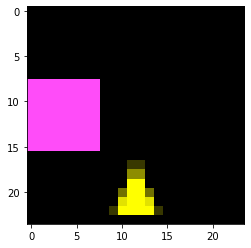

In [37]:
plt.imshow(dataset.observations[0,2].type(torch.int32))

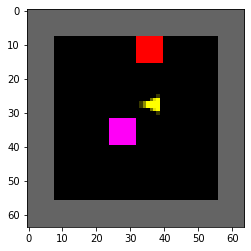

In [38]:
plt.imshow(dataset.full_observations[0,2].type(torch.int32))

In [7]:
dataset.observations.shape

torch.Size([50, 50, 24, 24, 3])

In [10]:
flat_obs = torch.flatten(dataset.observations, start_dim=0, end_dim=1)
flat_obs.shape

torch.Size([2500, 24, 24, 3])

In [11]:
torch.unique(flat_obs, dim=0).shape

torch.Size([98, 24, 24, 3])

Getting uniques..
Got uniques. Plotting...
Positive: 29 | Negative: 1738


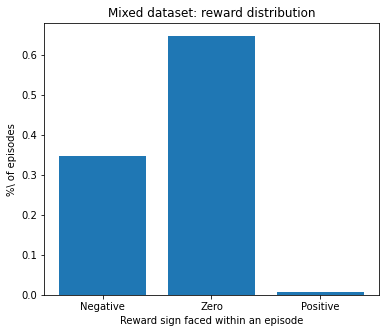

In [5]:
# data_path = 'agents/MiniGrid-Triggers-5x5-T1P1-v0/random/trajectories/train_10000.pt'
# data_path = 'agents/MiniGrid-Triggers-5x5-T1P1-v0/ep15000/trajectories/train.pt'
# data_path = 'agents/MiniGrid-Triggers-5x5-T1P1-v0/mixed/trajectories/train_10000.pt'
# data_path = 'agents/MiniGrid-Triggers-5x5-T1P1-v0/mixed/trajectories/test_5000.pt'
# data_path = 'agents/MiniGrid-Triggers-7x7-T1P1-v0/random/trajectories/train_10000.pt'
# data_path = 'agents/MiniGrid-Triggers-3x3-T1P1-v0/random/trajectories/train_50.pt'
# data_path = 'agents/MiniGrid-Triggers-FULL-T1P1-v0/random/trajectories/test_200.pt'
# data_path = 'agents/MiniGrid-Triggers-3x3-T3P1-v0/random/trajectories/train_10000.pt'
data_path = 'agents/MiniGrid-Triggers-3x3-T3P1-v0/random/trajectories/test_5000.pt'
dataset = torch.load(data_path)

rewards = dataset.rewards

print('Getting uniques..')
unique_rewards_per_episode = [torch.unique(rewards[episode]).tolist() for episode in range(rewards.shape[0])]
print('Got uniques. Plotting...')

n_episodes_positive_reward = 0
n_episodes_negative_reward = 0
for episode_reward_vals in unique_rewards_per_episode:
    if 2 in episode_reward_vals:
        n_episodes_positive_reward += 1
    if 0 in episode_reward_vals:
        n_episodes_negative_reward += 1

n_episodes_no_reward = rewards.shape[0] - n_episodes_positive_reward - n_episodes_negative_reward
reward_vals = torch.tensor([n_episodes_negative_reward, n_episodes_no_reward, n_episodes_positive_reward])

print(f'Positive: {n_episodes_positive_reward} | Negative: {n_episodes_negative_reward}')


plt.figure(figsize=(6,5))
plt.title('Mixed dataset: reward distribution')
plt.xlabel('Reward sign faced within an episode')
plt.ylabel('%\ of episodes')
plt.bar(torch.arange(0, 3)-1, reward_vals/torch.sum(reward_vals), tick_label=['Negative', 'Zero', 'Positive'])
plt.show()


# del n_episodes_no_reward
# del dataset
# del rewards
# del reward_vals
# import gc
# gc.collect()

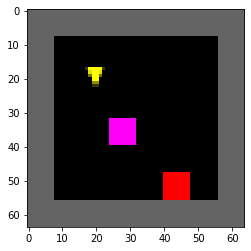

In [9]:
plt.imshow(dataset.observations[0, 0].type(torch.int32))

In [7]:
data_path = 'agents/MiniGrid-Triggers-5x5-T1P1-v0/random/trajectories/train_10000.pt'

dataset = torch.load(data_path)

print('obs size:', dataset.observations.shape)
print('act size:', dataset.actions.shape)
print('reward size:', dataset.rewards.shape)

obs size: torch.Size([10000, 50, 40, 40, 3])
act size: torch.Size([10000, 50, 3])
reward size: torch.Size([10000, 50])


15514

0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0')


returns tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       device='cuda:0')
preds tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0')


returns tensor([ 0,  0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       device='cuda:0')
preds tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0')


r

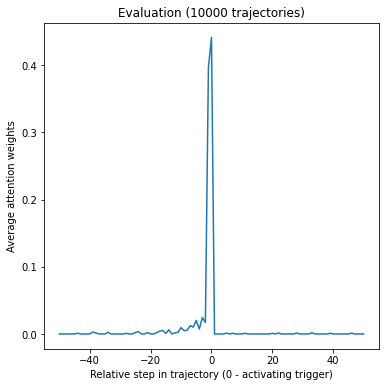

In [5]:
from train_reward_predictors import run_ca_evaluation
from config import ATTN_THRESHOLD

batch_size = 128
best_model_path = 'wandb/run-20210419_152906-7v8ji1ez/files/best_model.pt'
# test_path = 'agents/MiniGrid-Triggers-3x3-T1P1-v0/random/trajectories/test_5000_padded.pt'
test_path = 'agents/MiniGrid-Triggers-3x3-T1P1-v0/random/trajectories/train_10000_padded.pt'
obs_mean_path = 'agents/MiniGrid-Triggers-3x3-T1P1-v0/random/trajectories/train_10000_padded_mean.pt'
obs_std_path = 'agents/MiniGrid-Triggers-3x3-T1P1-v0/random/trajectories/train_10000_padded_std.pt'

use_returns = True
skip_no_trigger_episodes_precision = True


acc, ca_precision, ca_recall, axes, ca_gt, rel_attn_vals = run_ca_evaluation(best_model_path, test_path, obs_mean_path, obs_std_path, None, ATTN_THRESHOLD, batch_size, skip_no_trigger_episodes_precision, use_returns=use_returns, use_wandb=False)

print('acc:', acc)
print('ca_precision:', ca_precision)
print('ca_recall:', ca_recall)
# print('acc:', acc)

plt.show()

In [4]:
# from config import PAD_VAL

# dataset.rewards += 1

# padding_mask = (dataset.actions[:, :, 0] == PAD_VAL) # padded positions are True

# ep = 7
# print(f'padding mask for episode {ep}')
# print(padding_mask[ep])
print(f'rewards for episode {ep}')
# print(dataset.rewards[ep])

In [5]:
# dataset.rewards[padding_mask] = PAD_VAL # set padded steps to PAD_VAL

In [6]:
# print(f'rewards for episode {ep}')
# print(dataset.rewards[ep])

In [7]:
# torch.save(dataset, 'agents/MiniGrid-Triggers-3x3-T1P1-v0/random/trajectories/train_10000_padded.pt')

In [10]:
ca_gt

{'attention_threshold': 0.2,
 'batch_size': 128,
 'episodes_with_trigger_mask': tensor([0, 1, 0,  ..., 0, 0, 0], device='cuda:0'),
 'episodes_with_prize_mask': tensor([0, 0, 0,  ..., 0, 0, 1], device='cuda:0'),
 'seq_len': 50,
 'trigger_activations': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8),
 'trigger_timesteps': tensor([ 0, 24,  0,  ...,  0,  0,  0], device='cuda:0'),
 'prize_activations': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
 'prize_timesteps': tensor([0, 0, 0,  ..., 0, 0, 3])}

Touched trigger at step: 23
Got prize at step: 25


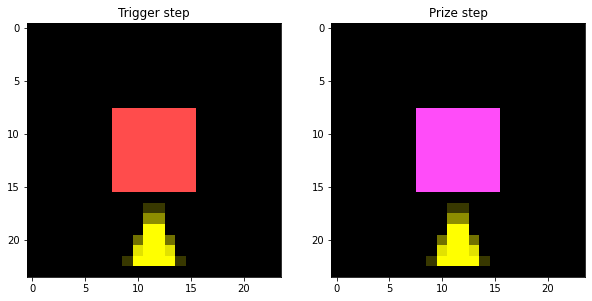

In [82]:
episode = 6

touched_trigger = bool(ca_gt['episodes_with_trigger_mask'][episode])
touched_prize = bool(ca_gt['episodes_with_prize_mask'][episode])

trigger_step = ca_gt['trigger_timesteps'][episode].item()
prize_step = ca_gt['prize_timesteps'][episode].item()

print('Touched trigger at step:', trigger_step if touched_trigger else 'never')
print('Got prize at step:', prize_step if touched_prize else 'never')

fig, axes = plt.subplots(1,2, figsize=(10,5))


axes[0].set_title('Trigger step')

if touched_trigger:
    axes[0].imshow(dataset.observations[episode,trigger_step].type(torch.int32))
else:
    axes[0].imshow(np.zeros_like(dataset.observations[episode,trigger_step]))

axes[1].set_title('Prize step')
if touched_prize:
    axes[1].imshow(dataset.observations[episode,prize_step].type(torch.int32))
else:
    axes[0].imshow(np.zeros_like(dataset.observations[episode,trigger_step]))

plt.show()

In [111]:
(ca_gt['episodes_with_prize_mask'] != 0).nonzero().squeeze()[:50]

tensor([  3,   4,   6,   7,  10,  11,  15,  16,  17,  19,  20,  27,  28,  29,
         30,  32,  33,  35,  36,  40,  42,  44,  45,  48,  51,  53,  54,  55,
         57,  58,  61,  62,  66,  67,  75,  76,  77,  79,  80,  82,  91,  92,
         99, 100, 103, 105, 112, 122, 123, 125], device='cuda:0')

In [5]:
import torch
from trajectories import TrajectoriesDataset

dataset = torch.load('agents/MiniGrid-Triggers-5x5-T1P1-v0/random/trajectories/train_10000.pt')

dataset.actions[1]

tensor([[ 1.,  0.,  0.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],


In [120]:
dataset.rewards[0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])

In [142]:
torch.unique(dataset.rewards[:7,:], dim=1, sorted=True)[:5,:]

tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 1]])

In [144]:
unique_rewards_per_episode[:10]

[tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([0, 1]),
 tensor([0, 1]),
 tensor([1]),
 tensor([0, 1, 2]),
 tensor([0, 1]),
 tensor([1]),
 tensor([1])]

tensor([ 1732,   495,  9626,  8584,  2524, 10144,   887, 18741,  4767, 17327])

In [41]:


def describe_dataset(dataset):
    print('observations', dataset.observations.shape)
    print('\n')
    print('actions', dataset.actions.shape)
    print('unique actions', torch.unique(dataset.actions))
    print('\n')
    print('rewards', dataset.rewards.shape)
    print('unique rewards:', torch.unique(dataset.rewards))

# describe_dataset(mixed_dataset)

# from config import PAD_VAL

# print('Converting rewards to reward classes...')
# mixed_dataset.rewards += 1

padding_mask = (mixed_dataset.actions[:, :, 0] == PAD_VAL) # padded positions are True

ep = 5
print(f'padding mask for episode {ep}')
print(padding_mask[ep])
# print(f'rewards for episode {ep}')
# print(mixed_dataset.rewards[ep])

# print('Padding...')
# mixed_dataset.rewards[padding_mask] = PAD_VAL # set padded steps to PAD_VAL
print(f'rewards for episode {ep}')
print(mixed_dataset.rewards[ep])

# torch.save(dataset, 'agents/MiniGrid-Triggers-3x3-T1P1-v0/random/trajectories/train_10000_padded.pt')

padding mask for episode 5
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])
rewards for episode 5
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])


Converting rewards to reward classes...
padding mask for episode 7
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])
rewards for episode 7
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])
Padding...
rewards for episode 7
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


In [16]:
padding_mask = (dataset.actions[:, :, 0] == PAD_VAL)
dataset.rewards[~padding_mask].shape

torch.Size([400570])

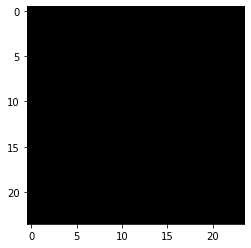

In [71]:
plt.imshow(dataset.observations[7,3])
plt.show()

In [9]:
from train_reward_predictors import run_ca_evaluation
from config import PAD_VAL, ATTN_THRESHOLD

BATCH_SIZE = 128

model_path = 'agents/MiniGrid-Triggers-3x3-T1P1-v0/ca-evaluation-3x3/model_s44_r1.000_p1.000_a0.879_l0.065.pt'
test_data_path = 'agents/MiniGrid-Triggers-3x3-T1P1-v0/random/trajectories/test.pt'

acc, ca_precision, ca_recall, axes = run_ca_evaluation(model_path, test_data_path, obs_mean_path, obs_std_path, None, ATTN_THRESHOLD, BATCH_SIZE, use_wandb=False)

print(f'Acc: {acc} | Pr: {ca_precision} | Rec: {ca_recall}')

plt.show()


    

/home/mbaliesnyi/anaconda3/envs/rl/lib/python3.8/site-packages/torch/tensor.py:758: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:930.)
  return super(Tensor, self).refine_names(names)


RuntimeError: mat1 dim 1 must match mat2 dim 0

Total reward: 1, tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


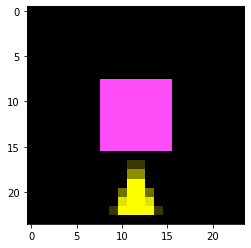

In [30]:
from reward_predictor import RewardPredictor

ACTION_SPACE_SIZE = dataset.actions.shape[-1]
OBSERVATION_SPACE_DIMS = [dataset.observations.shape[-1], *dataset.observations.shape[2:-1]]

# model = RewardPredictor(OBSERVATION_SPACE_DIMS, ACTION_SPACE_SIZE, device, verbose=False).to(device)

for i, batch in enumerate(train_loader):
    observations, actions, rewards, indices = batch

    rewards[episode] -= 1

    episode = 1
    step = 27
    print(f'Total reward: {torch.sum(rewards[episode])},', rewards[episode])

    plt.imshow(observations[episode,step].type(torch.int32))
    plt.show()
    break
    # print(torch.unique(returns))

    # observations = observations.transpose(2, 4).transpose(0, 1).to(device)
    # actions = actions.transpose(0, 1).to(device)
    # returns = returns.transpose(0, 1).to(device)

    # output = model(observations, actions)

    # print(output.shape)

unique: tensor([1, 2])
red tensor([255,  76,  76], dtype=torch.uint8)
pink tensor([255,  76, 249], dtype=torch.uint8)


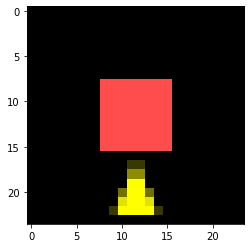

In [51]:
# debug
loader = DataLoader(dataset_new, batch_size=128)
episode = 3

for i, batch in enumerate(loader):
    observations, actions, reward, indices = batch

    # observations = observations.type(torch.FloatTensor)
    # observations[observations == 10] = 0

    # mean = torch.mean(observations, axis=(0,1,2,3))
    # std = torch.std(observations, axis=(0,1,2,3))
    # observations = (observations - mean) / std

    returns = torch.ones_like(reward) * 0
    sums = torch.sum(reward, axis=1)

    returns += sums[:, None]
    returns += 1
    print('unique:', torch.unique(returns))
    renormalized = (observations * std + mean).type(torch.ByteTensor)
    plt.imshow(renormalized[episode, 3, :, :, :])
    print('red',renormalized[episode, 3, 12, 12, :])
    print('pink',renormalized[episode, 7, 12, 12, :])
    plt.show()
    break